In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/MelanomaNevus/test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/melanoma/melanoma_1293.jpg  
  inflating: test/melanoma/melanoma_5279.jpg  
  inflating: test/melanoma/melanoma_6208.jpg  
  inflating: test/melanoma/melanoma_4028.jpg  
  inflating: test/melanoma/melanoma_2788.jpg  
  inflating: test/melanoma/melanoma_763.jpg  
  inflating: test/melanoma/melanoma_9333.jpg  
  inflating: test/melanoma/melanoma_2136.jpg  
  inflating: test/melanoma/melanoma_1577.jpg  
  inflating: test/melanoma/melanoma_551.jpg  
  inflating: test/melanoma/melanoma_1175.jpg  
  inflating: test/melanoma/melanoma_7346.jpg  
  inflating: test/melanoma/melanoma_8357.jpg  
  inflating: test/melanoma/melanoma_433.jpg  
  inflating: test/melanoma/melanoma_7396.jpg  
  inflating: test/melanoma/melanoma_5428.jpg  
  inflating: test/melanoma/melanoma_3885.jpg  
  inflating: test/melanoma/melanoma_5726.jpg  
  inflating: test/melanoma/melanoma_2503.jpg  
  inflating: test/melanoma/melanoma_8433.jpg  
  inflating:

In [ ]:
!cp /content/drive/MyDrive/MelanomaVenus/merged.csv /content/

cp: cannot stat '/content/drive/MyDrive/MelanomaVenus/merged.csv': No such file or directory


In [ ]:
data_dir_train = pathlib.Path("train") # путь к изобраениям для тренировки
data_dir_test = pathlib.Path("test") # путь к изобраениям для теста
dir_path = os.getcwd() # корневой путь
dir_path

'/content'

In [ ]:
# Загружаем файл датасета в pandas библиотеку для удобной работы с данными
df = pd.read_csv("merged.csv") # измени на путь к файлу merged.csv
df.head()

,image_name,diagnosis,target
0,ISIC_0052212,nevus,0
1,ISIC_0076995,nevus,0
2,ISIC_0084086,nevus,0
3,ISIC_0084270,nevus,0
4,ISIC_0084395,nevus,0


In [ ]:
nevus = df[df.diagnosis == 'nevus'].image_name.tolist() # список доброкачественных изображений в файле сверху
melanoma = df[df.diagnosis == 'melanoma'].image_name.tolist()# список изображений меланомы в файле сверху

# реальные файлы изображений в наших папках для тренировки (data_dir_train), путь к папках можно менятьб но он должен быть полным
files_train_nv = next(os.walk(os.path.join(dir_path, data_dir_train, 'nevus')), (None, None, []))[2]
files_train_mel = next(os.walk(os.path.join(dir_path, data_dir_train, 'melanoma')), (None, None, []))[2]

# мешаем данные списке
random.shuffle(nevus)
random.shuffle(melanoma)

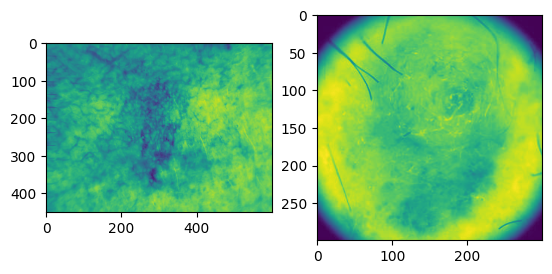

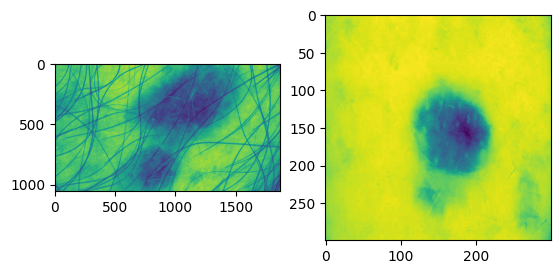

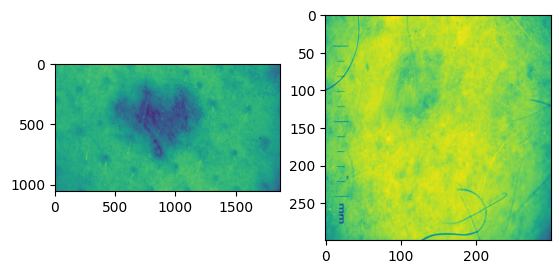

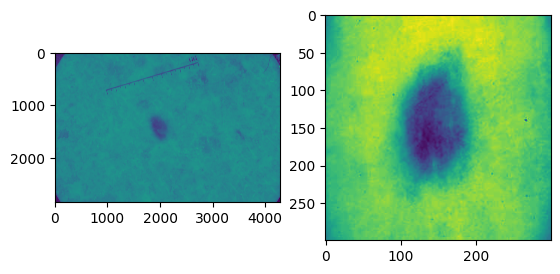

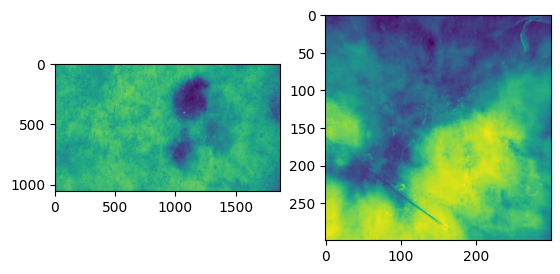

In [ ]:
k = 5 # счетчик вывода изображений
for img1, img2 in zip(nevus, melanoma):
    if k == 0:
        break
    # если сразу 2 избражения в папках, выводим сначала доброкачественное, затем справа меланому
    # стиль изображений COLOR_RGB2GRAY
    if img1+'.jpg' in files_train_nv and img2+'.jpg' in files_train_mel:
        image = cv2.imread(os.path.join('train/nevus', img1+'.jpg'))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        image2 = cv2.imread(os.path.join('train/melanoma', img2+'.jpg'))
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
        plt.show()
        k -= 1

### If we need to put images into classes folders for test and train

### Подготовка данных и использование первой модели


In [ ]:
batch_size = 16 # размер батча, то есть сколько иозбражений бодет подаваться модели на вхоодной слой
# размер изображения для обучения
img_height = 224
img_width = 224

In [ ]:
# используем tensorflow для создания препроцессовой выборки для тренировки
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2, # для валидации оставляем 20% от тренировочной выборки
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 18896 files belonging to 2 classes.
Using 15117 files for training.


In [ ]:
# то же самое для валидации
# https://habr.com/ru/articles/458170/ здесь можно почитать, зачем нужны валидационные данные в процессе обучения
# если коротко, они помогают модели не переобучаться
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 18896 files belonging to 2 classes.
Using 3779 files for validation.


In [ ]:
# то же самое для теста
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 6725 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names) # посмотрим на наши названия классов, они равны названим папок с изображениями

['melanoma', 'nevus']


In [ ]:
# Преобразование кэша может кэшировать набор данных либо в памяти, либо в локальном хранилище.
# Это позволит избежать выполнения некоторых операций (например, открытия файлов и чтения данных) в каждую эпоху.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height,
                                img_width,
                                3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


In [ ]:
# компилируем модель
# задаем оптимизатор adam
# loss - потери у нас вычисляются по формуле кроссэтропии
# метрика - accyracy (точность = количество правильных предсказаний / все предсказания)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                     

In [ ]:
epochs = 40 # сколько эпох будет обучаться
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
945/945 [==============================] - 125s 119ms/step - loss: 0.5276 - accuracy: 0.7387 - val_loss: 0.4971 - val_accuracy: 0.7539
Epoch 2/40
945/945 [==============================] - 105s 111ms/step - loss: 0.4828 - accuracy: 0.7691 - val_loss: 0.4582 - val_accuracy: 0.7804
Epoch 3/40
945/945 [==============================] - 103s 109ms/step - loss: 0.4615 - accuracy: 0.7849 - val_loss: 0.4329 - val_accuracy: 0.8097
Epoch 4/40
945/945 [==============================] - 104s 110ms/step - loss: 0.4508 - accuracy: 0.7924 - val_loss: 0.4200 - val_accuracy: 0.8089
Epoch 5/40
945/945 [==============================] - 102s 108ms/step - loss: 0.4387 - accuracy: 0.8025 - val_loss: 0.4232 - val_accuracy: 0.8060
Epoch 6/40
945/945 [==============================] - 102s 108ms/step - loss: 0.4372 - accuracy: 0.7965 - val_loss: 0.4320 - val_accuracy: 0.7923
Epoch 7/40
945/945 [==============================] - 100s 106ms/step - loss: 0.4267 - accuracy: 0.8017 - val_loss: 0.4018 -

In [ ]:
#model = keras.models.load_model('models/kerasSimpleняем обученную модель

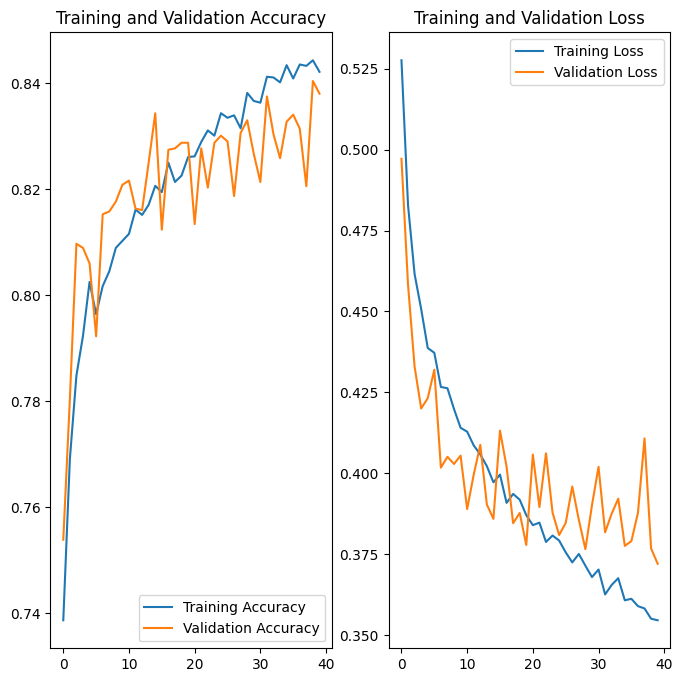

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## **Results of 20 epochs with augmentation while training kerasSimple.h5 (location: models/kerasSimple.h5)**

In [ ]:
# назначим набор аугментаций
# аугментации - изменения, которые будут происходить с изображениями до подачи самой модели

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height,
                                img_width,
                                3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                     

In [ ]:
epochs = 20 # сколько эпох будет обучаться
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
    )

Epoch 1/20
945/945 [==============================] - 99s 105ms/step - loss: 0.3504 - accuracy: 0.8455 - val_loss: 0.3823 - val_accuracy: 0.8304
Epoch 2/20
945/945 [==============================] - 99s 104ms/step - loss: 0.3507 - accuracy: 0.8485 - val_loss: 0.3771 - val_accuracy: 0.8343
Epoch 3/20
945/945 [==============================] - 98s 104ms/step - loss: 0.3477 - accuracy: 0.8468 - val_loss: 0.4255 - val_accuracy: 0.8169
Epoch 4/20
945/945 [==============================] - 97s 103ms/step - loss: 0.3478 - accuracy: 0.8526 - val_loss: 0.3753 - val_accuracy: 0.8306
Epoch 5/20
945/945 [==============================] - 97s 103ms/step - loss: 0.3431 - accuracy: 0.8520 - val_loss: 0.3925 - val_accuracy: 0.8275
Epoch 6/20
945/945 [==============================] - 96s 102ms/step - loss: 0.3415 - accuracy: 0.8553 - val_loss: 0.3828 - val_accuracy: 0.8304
Epoch 7/20
945/945 [==============================] - 98s 103ms/step - loss: 0.3497 - accuracy: 0.8501 - val_loss: 0.4014 - val_ac

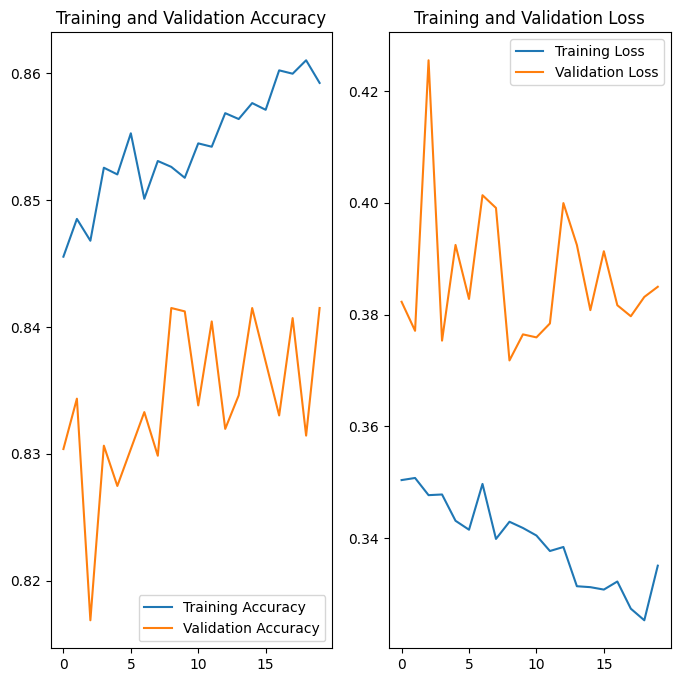

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(test_ds)

421/421 [==============================] - 9s 20ms/step - loss: 0.4136 - accuracy: 0.8286


[0.4136304557323456, 0.8285501599311829]

## Results of model without augmentations are worst (acc = 70%), than with augmentations (acc = 81%) on test

In [ ]:
model.save('model_keras_2_2.keras')

### Model with additional layers

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
87/87 [==============================] - 43s 493ms/step - loss: 0.6105 - accuracy: 0.7241 - val_loss: 0.5810 - val_accuracy: 0.7180
Epoch 2/10
87/87 [==============================] - 46s 532ms/step - loss: 0.5352 - accuracy: 0.7368 - val_loss: 0.5391 - val_accuracy: 0.7515
Epoch 3/10
87/87 [==============================] - 45s 517ms/step - loss: 0.5846 - accuracy: 0.7339 - val_loss: 0.5389 - val_accuracy: 0.7282
Epoch 4/10
87/87 [==============================] - 45s 520ms/step - loss: 0.5065 - accuracy: 0.7416 - val_loss: 0.5095 - val_accuracy: 0.7282
Epoch 5/10
87/87 [==============================] - 45s 518ms/step - loss: 0.5120 - accuracy: 0.7394 - val_loss: 0.4839 - val_accuracy: 0.7442
Epoch 6/10
87/87 [==============================] - 47s 536ms/step - loss: 0.5273 - accuracy: 0.7456 - val_loss: 0.5323 - val_accuracy: 0.7209
Epoch 7/10
87/87 [==============================] - 47s 542ms/step - loss: 0.5056 - accuracy: 0.7394 - val_loss: 0.4758 - val_accuracy: 0.7427

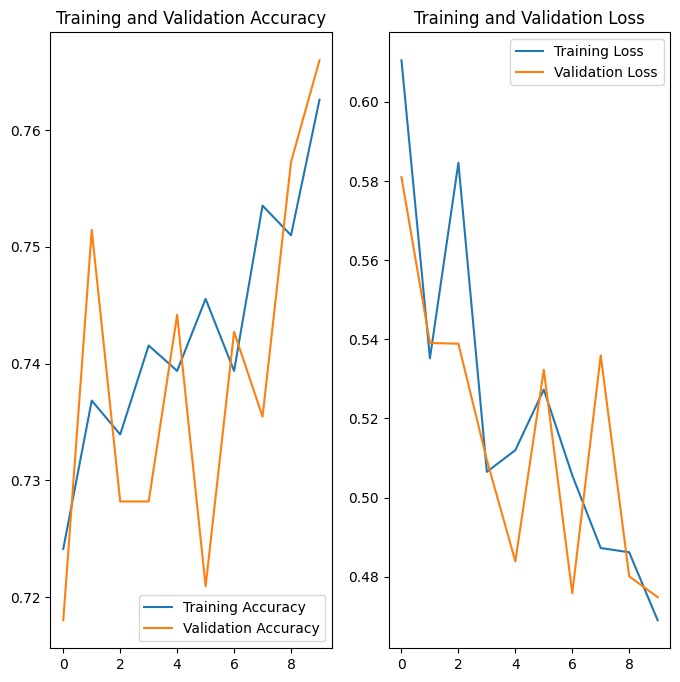

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Second variant**

**I used google colab power for using cuda resourses.
Folders of images for dataset upload from google drive**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os

In [ ]:
df = pd.read_csv('merged.csv')
df.head()

,Unnamed: 0,image_name,diagnosis,target
0,0,ISIC_0052212,nevus,0
1,1,ISIC_0076995,nevus,0
2,2,ISIC_0084086,nevus,0
3,3,ISIC_0084270,nevus,0
4,4,ISIC_0084395,nevus,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/train.zip

In [ ]:

data_dir_train = pathlib.Path("train")
data_dir_test = pathlib.Path("test")
dir_path = os.getcwd()

IMG_SIZE = 224
BATCH = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)
classes = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)

Found 18896 files belonging to 2 classes.
Using 15117 files for training.
Found 18896 files belonging to 2 classes.
Using 3779 files for validation.
Found 6725 files belonging to 2 classes.


In [ ]:
train_ds.cache().shuffle(buffer_size= len(train_ds)).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(buffer_size = len(val_ds)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(buffer_size = len(test_ds)).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
data_augmentating = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])

resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
])

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'

## **VGG16 model**

In [ ]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE,
                                IMG_SIZE,
                                3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.2),
    layers.Conv2D(filters = 64, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1),input_shape = (IMG_SIZE,IMG_SIZE,3)),
    layers.Conv2D(filters = 64, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(filters = 128, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 128, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(filters = 256, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 256, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 256, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 256, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(1000,activation = 'relu'),
    layers.Dense(265,activation = 'relu'),
    layers.Dense(len(classes),activation = 'softmax')
])

model.build(input_shape=(None,IMG_SIZE,IMG_SIZE,3))

In [ ]:


model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 136,853,613 (522.06 MB)

 Trainable params: 136,853,613 (522.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor= 'loss', patience=5,mode = 'min' ,verbose=1)

In [ ]:
EPOCHS = 10
import time
t = time.time()
history = model.fit(
    train_ds,
    shuffle = True,
    epochs = EPOCHS,
    batch_size = BATCH,
    validation_data = val_ds
)
done = time.time() - t
with open('real_time.txt', 'a') as f:
    f.write(f'time for keras2.0 model:=> {done}s\n')
done

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.5658 - loss: 0.6848 - val_accuracy: 0.5748 - val_loss: 0.6824
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.5671 - loss: 0.6844 - val_accuracy: 0.5748 - val_loss: 0.6822
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.5643 - loss: 0.6853 - val_accuracy: 0.5748 - val_loss: 0.6824
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.5664 - loss: 0.6844 - val_accuracy: 0.5748 - val_loss: 0.6822
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.5677 - loss: 0.6843 - val_accuracy: 0.5748 - val_loss: 0.6823
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.5655 - loss: 0.6846 - val_accuracy: 0.5748 - val_loss: 0.6822
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.5713 - loss: 0.6832 - val_accuracy: 0.5748 - val_loss: 0.6823
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.5668 - loss: 0.6843 - val_accu

2533.8740408420563

In [ ]:
model.save("model_vgg16_1_0.keras")

TypeError: Model.save() missing 1 required positional argument: 'filepath'

In [ ]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 KB 9.3 MB/s eta 0:00:00


### **Third model torch**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/images.zip

In [ ]:
filenames = next(os.walk('/content/images'), (None, None, []))[2]

In [ ]:
len(filenames)

5016

In [ ]:
class ownDataset(Dataset):
    def __init__(self, csv_file, root, transform=None):
        self.annot = pd.read_csv(csv_file)
        self.root = root
        self.transform = transform
    def __len__(self):
        return len(self.annot)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, str(self.annot.iloc[idx, 0])+'.jpg')
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annot.iloc[idx, 2]))

        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [ ]:

# Hyperparameters
num_epochs = 6
num_classes = 2
size = 224
batch_size = 100
learning_rate = 0.001

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Resize((size, size)),
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Normalize((0.1307,), (0.3081,))])

dir_path = os.getcwd()
print(dir_path)
#dir_path = '/content/drive/MyDrive'

# MNIST dataset
dataset = ownDataset(csv_file='mergedTorch.csv', root=str(os.path.join(dir_path, 'images')), transform=trans)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(5017*0.8), 5017-int(5017*0.8)])
# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
print(len(train_loader), len(test_loader))

/content
41 11


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

device(type='cuda')

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(56 * 56 * 64, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
x = torch.randn(1000, 1000).cuda()

# Use the tensor
y = x * 2

# Delete the tensor
del x

# Use the GPU memory for other variables
z = y * 3

In [ ]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images1, labels1 = images.cuda(), labels.cuda()
        # Run the forward pass
        outputs = model(images1)
        loss = criterion(outputs, labels1)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
      з  optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels1.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels1).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/6], Step [21/41], Loss: 0.6730, Accuracy: 68.00%
Epoch [2/6], Step [21/41], Loss: 0.6487, Accuracy: 66.00%
Epoch [3/6], Step [21/41], Loss: 0.6122, Accuracy: 69.00%
Epoch [4/6], Step [21/41], Loss: 0.6777, Accuracy: 67.00%


In [ ]:

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)

KeyboardInterrupt: 